# PREDICTING VANCOUVER WEATHER PROJECT REPORT

## Introduction
*** intro here ***


## Methods

We will use the temperature (Celsius), feels-like temperature (Celsius), humidity (g/m^3), cloud cover (%), sea level pressure, and the wind speed (km/h) in order to determine the expected weather. Before working with the actual data, we are planning to predict the weather type by using common sense. For example, when the temperature is high, the expected precipitation is likely going to be on the lower side. Higher wind speed would indicate the higher precipitation rate. Then, we will use the functions and code that we learned from classification lessons to determine the actual weather type for specific hours in Vancouver. We are planning to create several different scatterplots with different y-axis: temperature, humidity, cloud cover, sea level pressure, and wind speed. The date will be the x-axis and we will categorize each point as its weather type for all graphs.



First, we will load in the necesarry libraries

In [1]:
library(repr)
library(tidyverse)
library(tidymodels)
library(themis)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

ERROR: Error in library(themis): there is no package called ‘themis’


We will now read our data from the web

In [2]:
weather_data <- read_csv("https://raw.githubusercontent.com/DaffyDiamond/DSCI-100-Group-30/main/data/vancouver_hourly.csv")
head(weather_data, 5)

Rows: 17544 Columns: 24
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (5): name, preciptype, conditions, icon, stations
dbl  (18): temp, feelslike, dew, humidity, precip, precipprob, snow, snowdep...
dttm  (1): datetime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


name,datetime,temp,feelslike,dew,humidity,precip,precipprob,preciptype,snow,⋯,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,conditions,icon,stations
<chr>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
vancouver,2020-12-31 00:00:00,5.9,3.0,5.3,95.97,1.376,100,rain,0,⋯,1005.7,84.6,13,0,NA,0,NA,"Rain, Partially cloudy",rain,"71608099999,CWWA,71211099999,71784099999,71892099999,71042099999"
vancouver,2020-12-31 01:00:00,5.7,2.9,5.0,95.13,0.191,100,rain,0,⋯,1006.3,100.0,12,0,NA,0,NA,"Rain, Overcast",rain,"71608099999,CWWA,71211099999,71784099999,71892099999,71042099999"
vancouver,2020-12-31 02:00:00,5.8,3.5,4.9,93.72,0.606,100,rain,0,⋯,1007.4,71.2,16,0,NA,0,NA,"Rain, Partially cloudy",rain,"71608099999,CWWA,71211099999,71784099999,71892099999,71042099999"
vancouver,2020-12-31 03:00:00,5.7,3.7,4.8,94.11,0.108,100,rain,0,⋯,1008.5,80.7,24,0,NA,0,NA,"Rain, Partially cloudy",rain,"71608099999,CWWA,71211099999,71784099999,71892099999,71042099999"
vancouver,2020-12-31 04:00:00,5.5,3.5,5.1,96.73,2.166,100,rain,0,⋯,1009.6,100.0,6,0,NA,0,NA,"Rain, Overcast",rain,"CWWA,71211099999,71775099999,71784099999,71892099999,71042099999"


Next we clean the data by removing columns and rows that are unnecesarry to our project

In [3]:
# selected out variables that are irrelivant to our predictions
weather_cleaned <- weather_data |>
    select(datetime, temp, feelslike, humidity, sealevelpressure, windspeed, cloudcover, icon) |>
    rename(weather = icon) |>
# wind has been filtered out due to being statistically insignificant
    filter(!(weather == "wind"))

head(weather_cleaned, 5)

datetime,temp,feelslike,humidity,sealevelpressure,windspeed,cloudcover,weather
<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
2020-12-31 00:00:00,5.9,3.0,95.97,1005.7,14.3,84.6,rain
2020-12-31 01:00:00,5.7,2.9,95.13,1006.3,13.4,100.0,rain
2020-12-31 02:00:00,5.8,3.5,93.72,1007.4,10.7,71.2,rain
2020-12-31 03:00:00,5.7,3.7,94.11,1008.5,9.3,80.7,rain
2020-12-31 04:00:00,5.5,3.5,96.73,1009.6,9.2,100.0,rain


We are now ready to split the data into training and testing to prepare for classification, a seed is used so results can be replicated.

In [4]:
set.seed(1234)

weather_split <- initial_split(weather_cleaned, prop = 0.75, strata = weather)
weather_training <- training(weather_split)
weather_testing <- testing(weather_split)

We will now take a look at the preportions of our data

In [5]:
weather_amount <- weather_training |>
    group_by(weather) |>
    summarize(n())
weather_amount

weather,n()
<chr>,<int>
clear-day,908
clear-night,1190
cloudy,2834
partly-cloudy-day,2890
partly-cloudy-night,2218
rain,2879
snow,233


the proportions of the data appears to be quite unblanced, this means we will have to scale and balance the data in the recipe

In [6]:
weather_recipe <- recipe( weather ~ temp + feelslike + humidity + sealevelpressure + windspeed + cloudcover, data = weather_training) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors()) 

before we start the classification, we must first design the specification, ktune must be used to find the optimal k value.

In [7]:
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
      set_engine("kknn") |>
      set_mode("classification")
knn_tune

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


To find the optimal k value, we will be using 10 fold cross validation to ensure greater accuracy 

In [13]:
weather_vfold <- vfold_cv(weather_training, v = 5, strata = weather)

we will now create the resample workflow to help us find the ideal k value

In [19]:
set.seed(4321)
k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 10))
weather_k_results <- workflow() |>
      add_recipe(weather_recipe) |>
      add_model(knn_tune) |>
      tune_grid(resamples = weather_vfold, grid = k_vals) |>
      collect_metrics()
weather_k_results


x Fold2: preprocessor 1/1, model 1/1 (predictions):
  Error in `mutate()`:
  ! Problem while computing `.row = orig_rows`.
  ✖ `.row` must be size 2630 or 1, not 2631.



neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.6523131,4,0.005465227,Preprocessor1_Model01
1,roc_auc,hand_till,0.8029898,4,0.003745297,Preprocessor1_Model01
11,accuracy,multiclass,0.6930897,4,0.001780009,Preprocessor1_Model02
11,roc_auc,hand_till,0.9352862,4,0.002348743,Preprocessor1_Model02
21,accuracy,multiclass,0.6913812,4,0.003233039,Preprocessor1_Model03
21,roc_auc,hand_till,0.9394713,4,0.001671032,Preprocessor1_Model03
31,accuracy,multiclass,0.6866284,4,0.003099973,Preprocessor1_Model04
31,roc_auc,hand_till,0.9413360,4,0.002078753,Preprocessor1_Model04
41,accuracy,multiclass,0.6833966,4,0.004212672,Preprocessor1_Model05


after collecting the results, we will use a graph to help us visualize the ideal k value

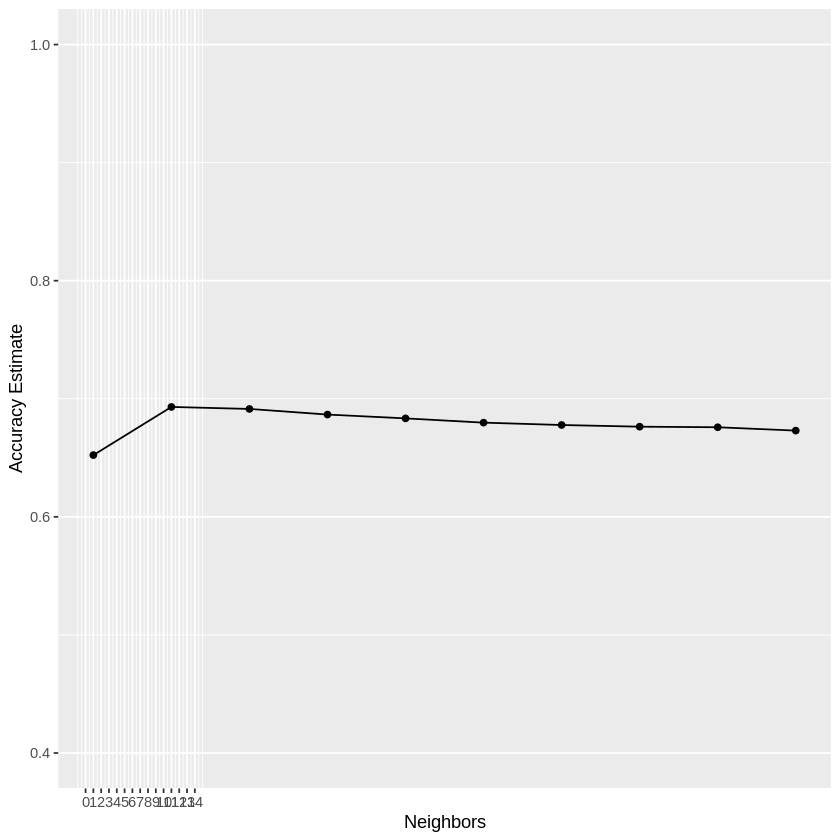

In [20]:
accuracies <- weather_k_results|> 
      filter(.metric == "accuracy")

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") +
      scale_x_continuous(breaks = seq(0, 14, by = 1)) +  # adjusting the x-axis
      scale_y_continuous(limits = c(0.4, 1.0)) # adjusting the y-axis


# your code here
accuracy_versus_k

To creat the workflow we will need to scale the data, due to the unbalanced proportions of the data, we will also have to balance using "step_upsample"